In [2]:
import pandas as pd
import os
import sys

In [3]:
sys.path.append("../src/ga4_mlops/pipelines")

In [4]:
from data_preparation_utils import extract_column_names

In [5]:
df = pd.read_csv('../data/05_model_input/abt_test.csv')

In [6]:
_, _, _, target_col = extract_column_names(df)
target_col

'y_added_to_cart'

In [7]:
df[target_col].value_counts()

0    1931
1      69
Name: y_added_to_cart, dtype: int64

In [8]:
df.shape[0]

2000

In [9]:
df[target_col].value_counts() / df.shape[0]

0    0.9655
1    0.0345
Name: y_added_to_cart, dtype: float64

In [10]:
n_obs = 500
seed = 42

In [11]:
frac = n_obs / df.shape[0]

In [12]:
df_sample = df.groupby(target_col).apply(lambda x: x.sample(frac=frac, random_state=seed)).reset_index(drop=True)
df_sample

,i_full_visitor_id,i_visit_start_time,i_date,c_device_category_desktop,c_device_category_mobile,c_device_category_tablet,c_is_mobile_0,c_is_mobile_1,c_operating_system_Web,c_operating_system_iOS,...,c_is_first_visit_0,c_is_first_visit_1,n_product_pages_viewed,n_total_hits,n_total_pageviews,n_total_visits,n_total_time_on_site,y_added_to_cart,c_weekday,c_visit_start_hour
0,1.662015e+07,1.611974e+15,20210130,1,0,0,0,1,1,0,...,0,1,0.0,4.0,2.0,1.0,45.000000,0,-1.0,3
1,5.150187e+07,1.612033e+15,20210130,1,0,0,0,1,1,0,...,0,1,0.0,4.0,2.0,1.0,3.000000,0,-1.0,13
2,3.829239e+06,1.612041e+15,20210130,1,0,0,0,1,0,0,...,0,1,0.0,6.0,2.0,1.0,3602.000000,0,-1.0,5
3,2.711459e+06,1.611972e+15,20210130,0,1,0,1,0,0,0,...,0,1,0.0,3.0,1.0,1.0,26661.463153,0,-1.0,16
4,4.689428e+06,1.611974e+15,20210130,0,1,0,1,0,0,0,...,0,1,0.0,5.0,2.0,1.0,2649.000000,0,-1.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5.033537e+06,1.611965e+15,20210130,0,1,0,1,0,0,1,...,0,1,1.0,29.0,10.0,1.0,9114.000000,1,-1.0,18
496,6.800885e+07,1.611966e+15,20210130,1,0,0,0,1,0,0,...,1,0,1.0,32.0,9.0,1.0,32258.000000,1,-1.0,18
497,5.987171e+06,1.612038e+15,20210130,1,0,0,0,1,0,0,...,1,0,1.0,13.0,3.0,1.0,253806.000000,1,-1.0,8
498,1.722062e+07,1.612014e+15,20210130,0,1,0,1,0,1,0,...,1,0,1.0,152.0,44.0,1.0,36785.000000,1,-1.0,15


In [13]:
df_sample[target_col].value_counts()

0    483
1     17
Name: y_added_to_cart, dtype: int64

In [14]:
df_sample.shape[0]

500

In [15]:
proportions = df_sample[target_col].value_counts() / df_sample.shape[0]
proportions

0    0.966
1    0.034
Name: y_added_to_cart, dtype: float64

In [16]:
proportions.to_string()

'0    0.966\n1    0.034'

---

In [17]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
sys.path.append("../src/ga4_mlops/pipelines")
from data_preparation_utils import extract_column_names

/Users/pchaberski/projects/gid-ml-framework/ga4-mlops/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def sample_data(abt: pd.DataFrame, n_obs: int, seed: int) -> pd.DataFrame:
    """Sample model input data preserving target proportions.

    Args:
        abt (pd.DataFrame): input data frame
        n_obs (int): number of observations in a sample

    Returns:
        pd.DataFrame: data frame sample
    """
    original_n_obs = abt.shape[0]
    n_obs = max(1, min(n_obs, original_n_obs))
    # logger.info(
    #     f"Sampling data for SHAP explanations. Original size: {original_n_obs}; Sample size: {n_obs}"
    # )

    _, _, _, target_col = extract_column_names(abt)
    # logger.info(f"Target name: {target_col}")

    original_proportions = abt[target_col].value_counts() / original_n_obs
    # logger.info(f"Original target proportions:\n{original_proportions.to_string()}")

    frac = n_obs / original_n_obs
    abt_sample = (
        abt.groupby(target_col)
        .apply(lambda x: x.sample(frac=frac, random_state=seed))
        .reset_index(drop=True)
    )

    proportions = abt_sample[target_col].value_counts() / n_obs
    # logger.info(f"Sample target proportions:\n{proportions.to_string()}")

    return abt_sample

In [19]:
abt_train = pd.read_csv('../data/05_model_input/abt_train.csv')
abt = pd.read_csv('../data/05_model_input/abt_test.csv')

In [20]:
abt_train_sample = sample_data(abt_train, 100, 42)
abt_sample = sample_data(abt, 100, 42)

_, num_cols, cat_cols, _ = extract_column_names(abt_train_sample)

features_train_sample = abt_train_sample[num_cols + cat_cols]
features_sample = abt_sample[num_cols + cat_cols]

In [21]:
with open('../data/06_models/model.pkl', 'rb') as pickle_file:
    model = pickle.load(pickle_file)

In [22]:
explainer = shap.KernelExplainer(model.predict_proba, features_train_sample)

In [23]:
shap_values = explainer.shap_values(features_sample)

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


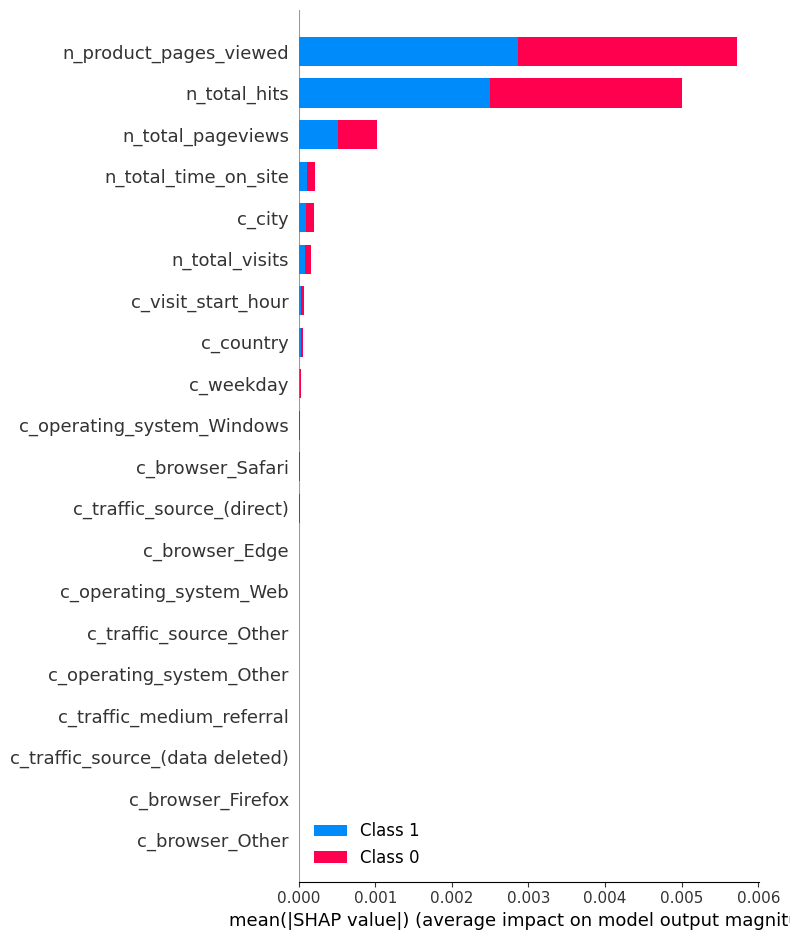

In [24]:
shap.summary_plot(shap_values, features=features_sample)

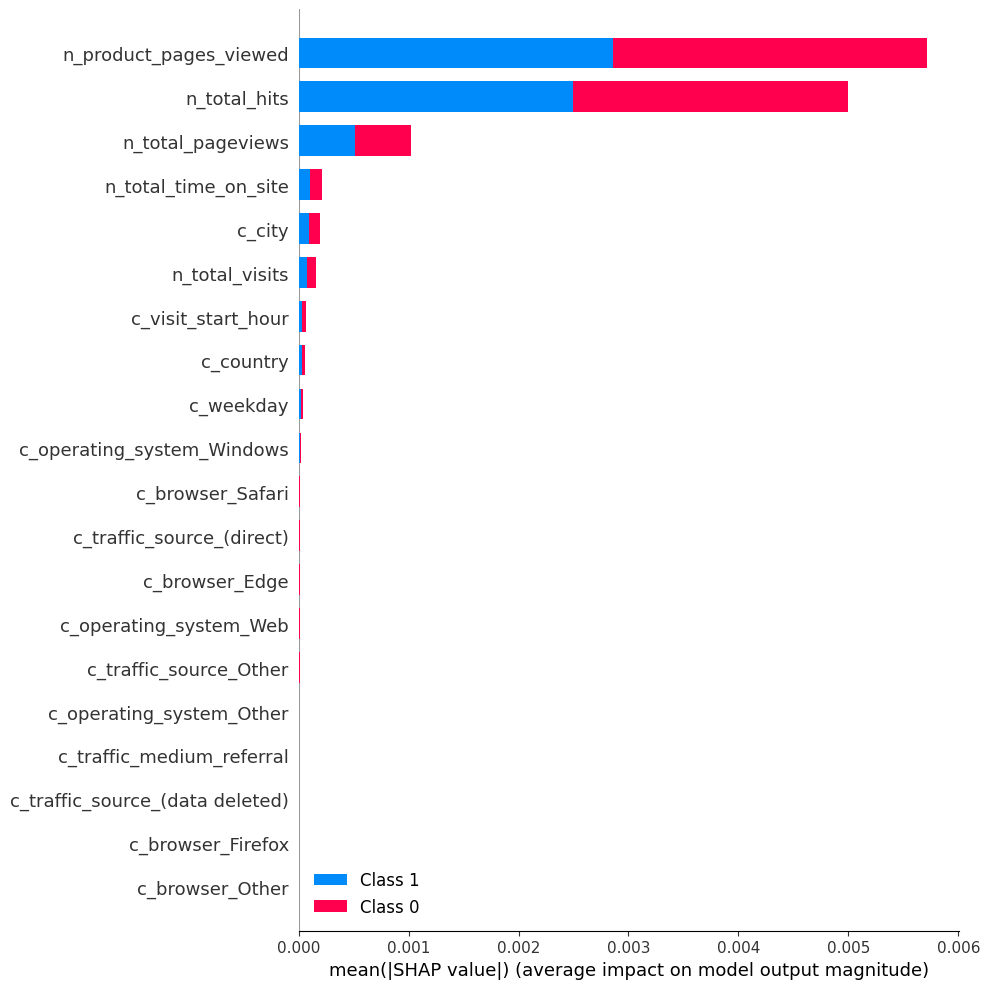

In [25]:
shap.summary_plot(shap_values, features=features_sample, plot_size=(10, 10))

In [26]:
features_sample.columns[np.argsort(np.abs(shap_values).mean(0))]

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


array([['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_total_hits', 'n_product_pages_viewed'],
       ...,
       ['c_browser_Android Webview', 'c_browser_Firefox', 'c_country',
        ..., 'n_total_time_on_site', 'n_product_pages_viewed',
        'n_total_hits'],
       ['c_browser_Android Webview', 'c_traffic_medium_(none)',
        'c_traffic_source_(data deleted)', ..., 'n_total_pageviews',
        'n_total_hits', 'n_product_pages_viewed'],
       ['c_browser_Android Webview', 'c_country', 'c_city', ...,
        'n_total_pageviews', 'n_product_pages_viewed', 'n_total_hits']],
      dtype=object)

In [27]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(features_sample.columns, sum(vals))), columns=['feature','importance'])
feature_importance.sort_values(by=['importance'], ascending=False, inplace=True)
feature_importance

,feature,importance
0,n_product_pages_viewed,0.285889
1,n_total_hits,0.249955
2,n_total_pageviews,0.051016
4,n_total_time_on_site,0.010638
23,c_city,0.009859
3,n_total_visits,0.007963
39,c_visit_start_hour,0.003438
22,c_country,0.002993
38,c_weekday,0.001777
12,c_operating_system_Windows,0.000912


In [28]:
# feature_importance = dict(zip(features_sample.columns, sum(vals)))
# feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
# feature_importance

In [29]:
{k: v for k, v in zip(feature_importance["feature"], feature_importance["importance"])}

{'n_product_pages_viewed': 0.28588916594851366,
 'n_total_hits': 0.2499548537035486,
 'n_total_pageviews': 0.05101619068664535,
 'n_total_time_on_site': 0.010637537536838665,
 'c_city': 0.009858768661363707,
 'n_total_visits': 0.00796279236250708,
 'c_visit_start_hour': 0.0034380265705851376,
 'c_country': 0.0029934533798998434,
 'c_weekday': 0.001776800099043234,
 'c_operating_system_Windows': 0.000912437277875522,
 'c_browser_Safari': 0.0006262115339353725,
 'c_traffic_source_(direct)': 0.000609475628051133,
 'c_browser_Edge': 0.0005704310166512187,
 'c_operating_system_Web': 0.0005488890658911556,
 'c_traffic_source_Other': 0.000530438624614202,
 'c_operating_system_Other': 0.00032777302719599313,
 'c_traffic_medium_referral': 0.000267439953780919,
 'c_traffic_source_(data deleted)': 0.00023782886868634667,
 'c_browser_Firefox': 0.00022618888008772147,
 'c_browser_Other': 0.00020854164454278277,
 'c_is_mobile_1': 0.00015907992764974815,
 'c_browser_Android Webview': 0.00015564143630

In [30]:
feature_importance.index[:5].to_list()

[0, 1, 2, 4, 23]

In [31]:
# top_5_features = feature_importance["feature"].head(5).to_list()
top_5_features = feature_importance.index[:5].to_list()
top_5_features

[0, 1, 2, 4, 23]

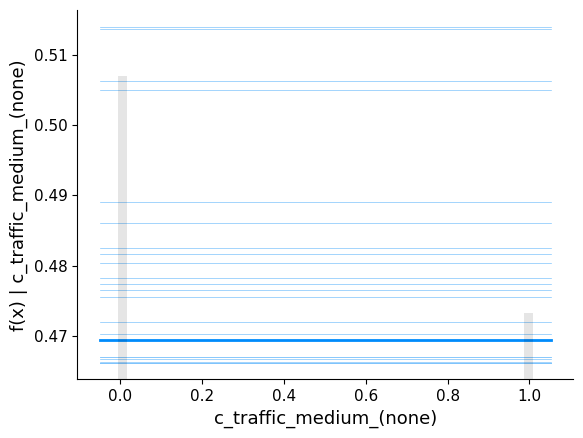

In [32]:
shap.plots.partial_dependence(30, lambda x: model.predict_proba(x)[:, 1], features_sample)

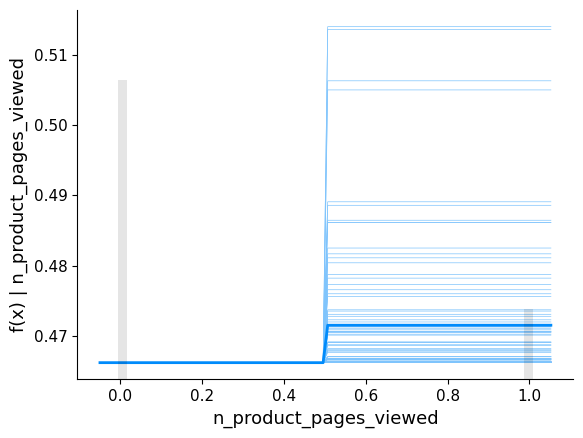

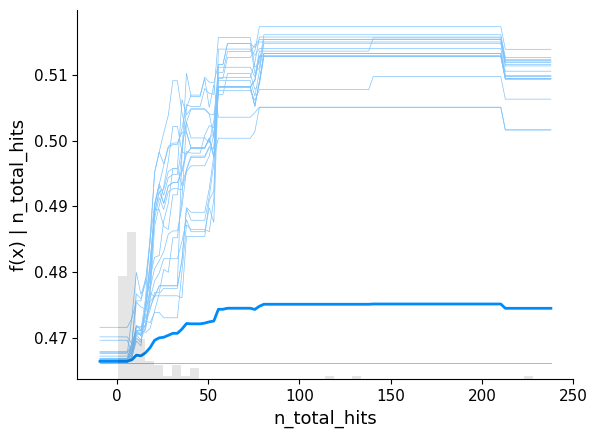

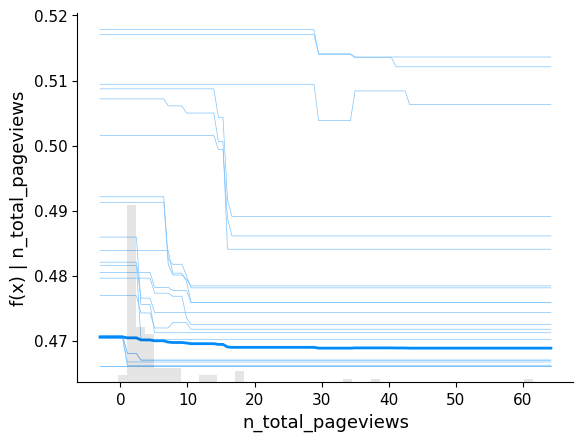

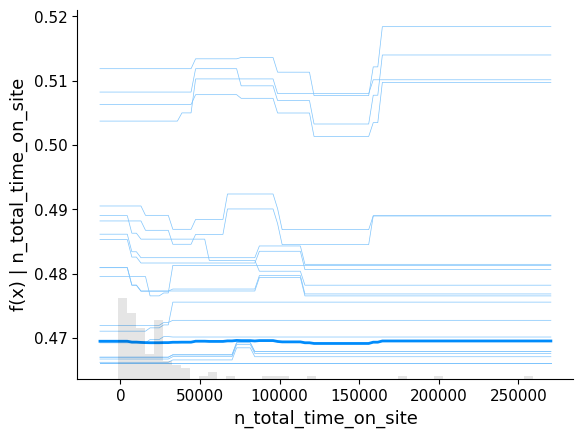

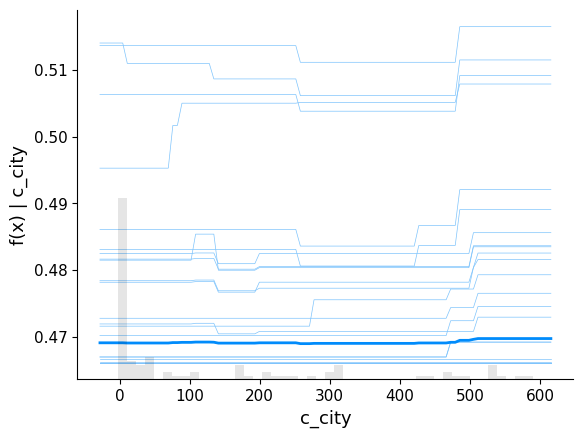

In [33]:
for idx in top_5_features:
    shap.plots.partial_dependence(idx, lambda x: model.predict_proba(x)[:, 1], features_sample)

In [34]:
type(shap_values)

list

---

In [35]:
import matplotlib.pyplot as plt
import io

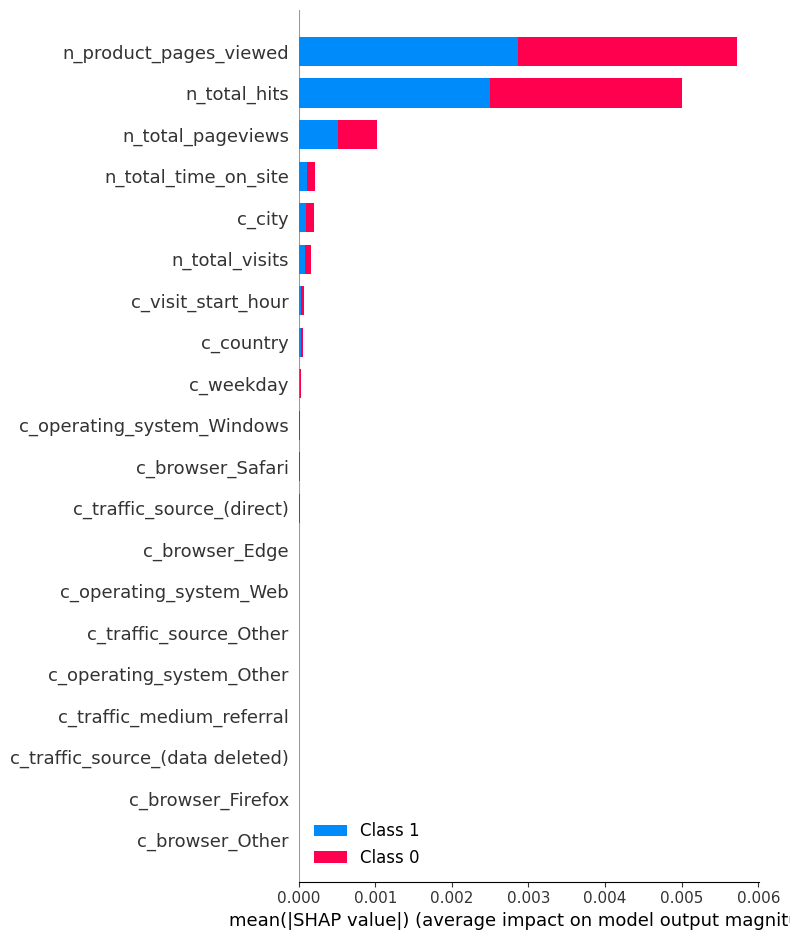

In [36]:
shap.summary_plot(
    shap_values,
    features=features_sample,
    show=False
)
fig = plt.gcf()
# plt.plot()

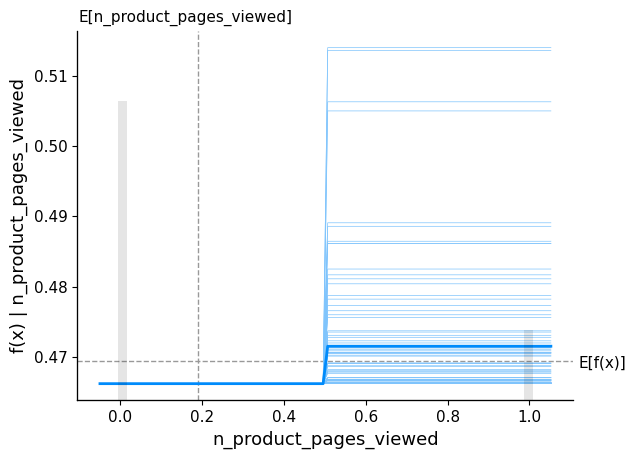

In [37]:
shap.plots.partial_dependence(
    0,
    lambda x: model.predict_proba(x)[:, 1],
    features_sample,
    model_expected_value=True,
    feature_expected_value=True,
    show=False
)
fig = plt.gcf()
# plt.plot()

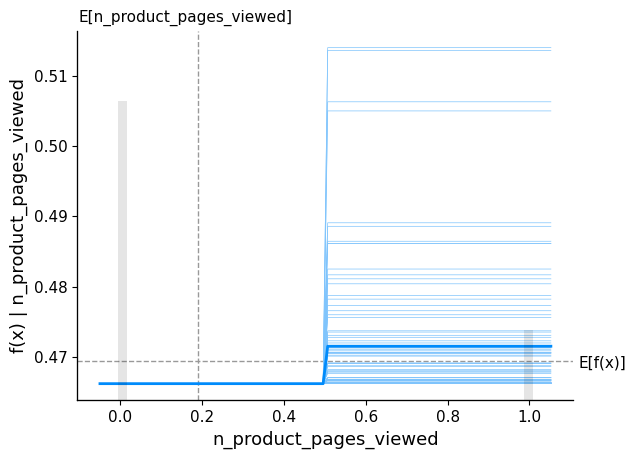

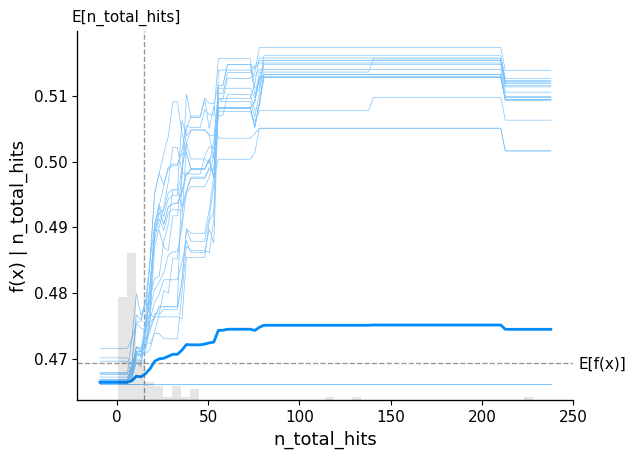

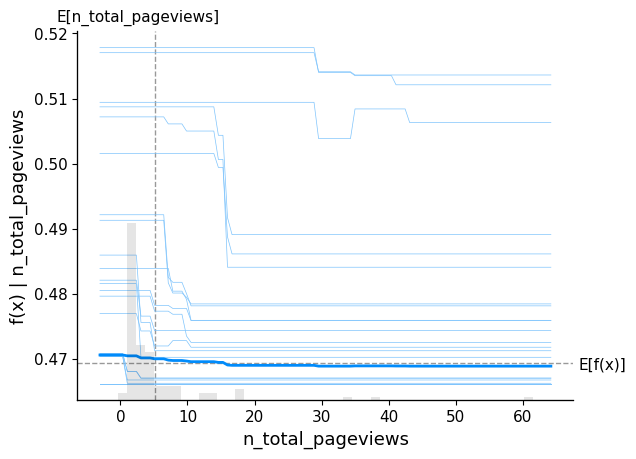

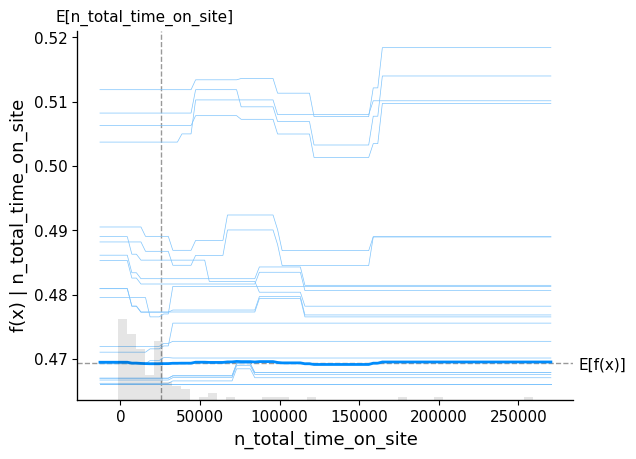

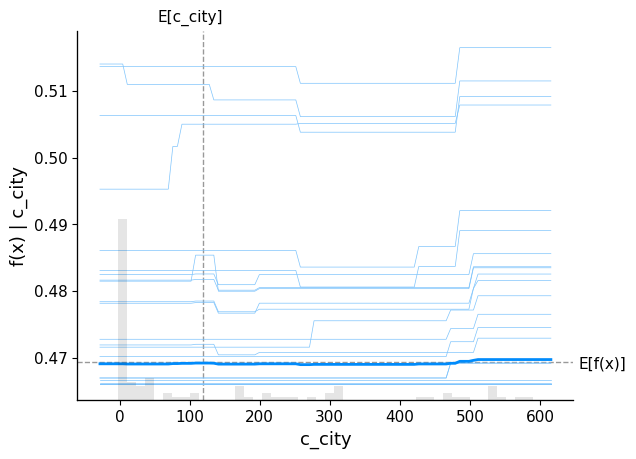

In [38]:
plots_dict = dict()
for idx in top_5_features:
    shap.plots.partial_dependence(
        idx,
        lambda x: model.predict_proba(x)[:, 1],
        features_sample,
        model_expected_value=True,
        feature_expected_value=True,
        show=False
    )
    feature_name = feature_importance["feature"][idx]
    plots_dict[f"{feature_name}.png"] = plt.gcf()
    # plt.plot()